In [2]:
import tensorflow as tf

#显示用cpu or gpu
#tf.debugging.set_log_device_placement(True)

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 14s 226us/sample - loss: 0.2206 - accuracy: 0.9345
Epoch 2/5
60000/60000 [==============================] - 12s 202us/sample - loss: 0.0979 - accuracy: 0.9703
Epoch 3/5
60000/60000 [==============================] - 12s 200us/sample - loss: 0.0687 - accuracy: 0.9785
Epoch 4/5
60000/60000 [==============================] - 11s 184us/sample - loss: 0.0539 - accuracy: 0.9827
Epoch 5/5
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0440 - accuracy: 0.9854
10000/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06411207508184016, 0.9811]

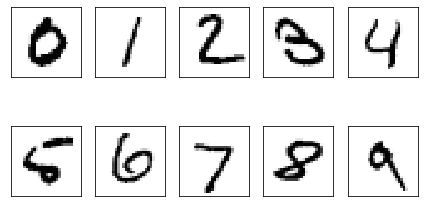

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )

ax = ax.flatten()
for i in range(10):
    img = x_test[y_test == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [3]:
y_test[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

# 2、房产测试 神经网络+随机参数搜索

In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import matplotlib as mpl
import pandas as pd
import numpy as np
import sklearn
import time
import sys
import os

# 加载数据
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)   # (20640, 8)
print(housing.target.shape) # (20640, )

# 切分数据集
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape) # (11610, 8) (11610,)
print(x_valid.shape, y_valid.shape) # (3870, 8) (3870,)
print(x_test.shape, y_test.shape)   # (5160, 8) (5160,)

# 数据归一化 x = (x - u) / d
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

# 建模
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,layer_size = 30,learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',input_shape=x_train.shape[1:]))
    
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation = 'relu'))    
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model


sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model)
#sklearn_model.summary()
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
# history = sklearn_model.fit(x_train_scaled, y_train,
#                             epochs = 10,
#                             validation_data = (x_valid_scaled, y_valid),
#                             callbacks = callbacks)

# 超参数搜索
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b
param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),}

from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)
# cross_validation: 训练集分成n份，n-1训练，最后一份验证.cv参数来控制
print('最佳参数：', random_search_cv.best_params_)    # 返回最佳参数组合
print('最佳评分：', random_search_cv.best_score_)     # 返回最佳评分 sklearn中回归问题默认mse
print('最佳模型：',random_search_cv.best_estimator_) # 返回最佳模型

# 得到最佳模型并预测
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

(20640, 8)
(20640,)
(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 3s 372us/sample - loss: 1.5820 - val_loss: 0.8072
Epoch 2/100
7740/7740 [==============================] - 1s 179us/sample - loss: 0.7348 - val_loss: 0.7342
Epoch 3/100
7740/7740 [==============================] - 1s 176us/sample - loss: 0.6713 - val_loss: 0.6861
Epoch 4/100
7740/7740 [==============================] - 1s 175us/sample - loss: 0.6262 - val_loss: 0.6464
Epoch 5/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.5893 - val_loss: 0.6075
Epoch 6/100
7740/7740 [==============================] - 1s 175us/sample - loss: 0.5600 - val_loss: 0.5764
Epoch 7/100
7740/7740 [==============================] - 1s 175us/sample - loss: 0.5356 - val_loss: 0.5518
Epoch 8/100
7740/7740 [==============================] - 2s 210us/sample - loss: 0.5158 - val_loss: 0.5318
Epoch 9/100
7740/774

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 230us/sample - loss: 1.6510 - val_loss: 0.8390
Epoch 2/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.7134 - val_loss: 0.7431
Epoch 3/100
7740/7740 [==============================] - 1s 169us/sample - loss: 0.6526 - val_loss: 0.6891
Epoch 4/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.6117 - val_loss: 0.6492
Epoch 5/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.5796 - val_loss: 0.6161
Epoch 6/100
7740/7740 [==============================] - 1s 192us/sample - loss: 0.5526 - val_loss: 0.5871
Epoch 7/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.5300 - val_loss: 0.5645
Epoch 8/100
7740/7740 [==============================] - 1s 171us/sample - loss: 0.5115 - val_loss: 0.5470
Epoch 9/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.4974 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 247us/sample - loss: 1.4896 - val_loss: 0.7690
Epoch 2/100
7740/7740 [==============================] - 1s 170us/sample - loss: 0.6385 - val_loss: 0.6766
Epoch 3/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.5837 - val_loss: 0.6328
Epoch 4/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.5508 - val_loss: 0.5997
Epoch 5/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.5241 - val_loss: 0.5711
Epoch 6/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.5030 - val_loss: 0.5487
Epoch 7/100
7740/7740 [==============================] - 1s 171us/sample - loss: 0.4864 - val_loss: 0.5307
Epoch 8/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.4714 - val_loss: 0.5142
Epoch 9/100
7740/7740 [==============================] - 1s 177us/sample - loss: 0.4592 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 227us/sample - loss: 5.4966 - val_loss: 4.3964
Epoch 2/100
7740/7740 [==============================] - 1s 173us/sample - loss: 3.4335 - val_loss: 2.8955
Epoch 3/100
7740/7740 [==============================] - 1s 169us/sample - loss: 2.3355 - val_loss: 2.0526
Epoch 4/100
7740/7740 [==============================] - 1s 173us/sample - loss: 1.7000 - val_loss: 1.5651
Epoch 5/100
7740/7740 [==============================] - 1s 172us/sample - loss: 1.3244 - val_loss: 1.2807
Epoch 6/100
7740/7740 [==============================] - 2s 217us/sample - loss: 1.1075 - val_loss: 1.1080
Epoch 7/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.9716 - val_loss: 0.9966
Epoch 8/100
7740/7740 [==============================] - 1s 175us/sample - loss: 0.8840 - val_loss: 0.9224
Epoch 9/100
7740/7740 [==============================] - 1s 176us/sample - loss: 0.8258 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 243us/sample - loss: 4.7107 - val_loss: 3.7859
Epoch 2/100
7740/7740 [==============================] - 1s 178us/sample - loss: 2.9171 - val_loss: 2.4740
Epoch 3/100
7740/7740 [==============================] - 1s 168us/sample - loss: 1.9656 - val_loss: 1.7631
Epoch 4/100
7740/7740 [==============================] - 1s 170us/sample - loss: 1.4465 - val_loss: 1.3691
Epoch 5/100
7740/7740 [==============================] - 1s 169us/sample - loss: 1.1615 - val_loss: 1.1462
Epoch 6/100
7740/7740 [==============================] - 1s 193us/sample - loss: 0.9957 - val_loss: 1.0134
Epoch 7/100
7740/7740 [==============================] - 1s 182us/sample - loss: 0.8948 - val_loss: 0.9302
Epoch 8/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.8304 - val_loss: 0.8755
Epoch 9/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.7875 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 241us/sample - loss: 4.7341 - val_loss: 3.8768
Epoch 2/100
7740/7740 [==============================] - 2s 200us/sample - loss: 3.0481 - val_loss: 2.6314
Epoch 3/100
7740/7740 [==============================] - 1s 175us/sample - loss: 2.1720 - val_loss: 1.9662
Epoch 4/100
7740/7740 [==============================] - 1s 171us/sample - loss: 1.6631 - val_loss: 1.5708
Epoch 5/100
7740/7740 [==============================] - 1s 170us/sample - loss: 1.3494 - val_loss: 1.3263
Epoch 6/100
7740/7740 [==============================] - 1s 172us/sample - loss: 1.1494 - val_loss: 1.1643
Epoch 7/100
7740/7740 [==============================] - 1s 170us/sample - loss: 1.0178 - val_loss: 1.0552
Epoch 8/100
7740/7740 [==============================] - 1s 184us/sample - loss: 0.9311 - val_loss: 0.9800
Epoch 9/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.8725 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 257us/sample - loss: 4.4707 - val_loss: 3.2556
Epoch 2/100
7740/7740 [==============================] - 1s 182us/sample - loss: 2.3486 - val_loss: 1.8727
Epoch 3/100
7740/7740 [==============================] - 2s 229us/sample - loss: 1.5333 - val_loss: 1.3819
Epoch 4/100
7740/7740 [==============================] - 1s 190us/sample - loss: 1.2277 - val_loss: 1.1569
Epoch 5/100
7740/7740 [==============================] - 2s 203us/sample - loss: 1.0525 - val_loss: 1.0090
Epoch 6/100
7740/7740 [==============================] - 2s 198us/sample - loss: 0.9249 - val_loss: 0.8976
Epoch 7/100
7740/7740 [==============================] - 1s 193us/sample - loss: 0.8293 - val_loss: 0.8175
Epoch 8/100
7740/7740 [==============================] - 1s 188us/sample - loss: 0.7613 - val_loss: 0.7622
Epoch 9/100
7740/7740 [==============================] - 2s 197us/sample - loss: 0.7151 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 250us/sample - loss: 4.2709 - val_loss: 2.7516
Epoch 2/100
7740/7740 [==============================] - 1s 181us/sample - loss: 1.9185 - val_loss: 1.3856
Epoch 3/100
7740/7740 [==============================] - 1s 181us/sample - loss: 1.1136 - val_loss: 0.9561
Epoch 4/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.8713 - val_loss: 0.8279
Epoch 5/100
7740/7740 [==============================] - 2s 207us/sample - loss: 0.7744 - val_loss: 0.7760
Epoch 6/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.7194 - val_loss: 0.7484
Epoch 7/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.6891 - val_loss: 0.7294
Epoch 8/100
7740/7740 [==============================] - 1s 190us/sample - loss: 0.6701 - val_loss: 0.7153
Epoch 9/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.6560 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 255us/sample - loss: 3.7486 - val_loss: 2.1699
Epoch 2/100
7740/7740 [==============================] - 1s 182us/sample - loss: 1.5095 - val_loss: 1.2753
Epoch 3/100
7740/7740 [==============================] - 1s 179us/sample - loss: 1.0912 - val_loss: 1.0790
Epoch 4/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.9222 - val_loss: 0.9721
Epoch 5/100
7740/7740 [==============================] - 2s 209us/sample - loss: 0.8447 - val_loss: 0.9147
Epoch 6/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.8004 - val_loss: 0.8796
Epoch 7/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.7720 - val_loss: 0.8551
Epoch 8/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.7520 - val_loss: 0.8361
Epoch 9/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.7364 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 273us/sample - loss: 1.6968 - val_loss: 0.8027
Epoch 2/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.6906 - val_loss: 0.6835
Epoch 3/100
7740/7740 [==============================] - 1s 177us/sample - loss: 0.6262 - val_loss: 0.6321
Epoch 4/100
7740/7740 [==============================] - 1s 180us/sample - loss: 0.5848 - val_loss: 0.5960
Epoch 5/100
7740/7740 [==============================] - 1s 188us/sample - loss: 0.5573 - val_loss: 0.5655
Epoch 6/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.5309 - val_loss: 0.5452
Epoch 7/100
7740/7740 [==============================] - 2s 239us/sample - loss: 0.5111 - val_loss: 0.5223
Epoch 8/100
7740/7740 [==============================] - 2s 288us/sample - loss: 0.4920 - val_loss: 0.5066
Epoch 9/100
7740/7740 [==============================] - 2s 224us/sample - loss: 0.4772 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 249us/sample - loss: 1.9896 - val_loss: 0.8707
Epoch 2/100
7740/7740 [==============================] - 1s 182us/sample - loss: 0.6956 - val_loss: 0.6363
Epoch 3/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.5793 - val_loss: 0.5904
Epoch 4/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.5404 - val_loss: 0.5583
Epoch 5/100
7740/7740 [==============================] - 1s 176us/sample - loss: 0.5125 - val_loss: 0.5325
Epoch 6/100
7740/7740 [==============================] - 2s 199us/sample - loss: 0.4906 - val_loss: 0.5097
Epoch 7/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.4733 - val_loss: 0.4939
Epoch 8/100
7740/7740 [==============================] - 1s 186us/sample - loss: 0.4588 - val_loss: 0.4776
Epoch 9/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.4470 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 276us/sample - loss: 1.3975 - val_loss: 0.7563
Epoch 2/100
7740/7740 [==============================] - 1s 180us/sample - loss: 0.6501 - val_loss: 0.6638
Epoch 3/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.5848 - val_loss: 0.6211
Epoch 4/100
7740/7740 [==============================] - 1s 193us/sample - loss: 0.5525 - val_loss: 0.5930
Epoch 5/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.5317 - val_loss: 0.5766
Epoch 6/100
7740/7740 [==============================] - 2s 201us/sample - loss: 0.5150 - val_loss: 0.5579
Epoch 7/100
7740/7740 [==============================] - 2s 208us/sample - loss: 0.5014 - val_loss: 0.5433
Epoch 8/100
7740/7740 [==============================] - 2s 210us/sample - loss: 0.4884 - val_loss: 0.5291
Epoch 9/100
7740/7740 [==============================] - 2s 207us/sample - loss: 0.4758 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 238us/sample - loss: 5.1896 - val_loss: 4.6436
Epoch 2/100
7740/7740 [==============================] - 1s 166us/sample - loss: 3.8604 - val_loss: 3.5555
Epoch 3/100
7740/7740 [==============================] - 1s 169us/sample - loss: 3.0144 - val_loss: 2.8354
Epoch 4/100
7740/7740 [==============================] - 1s 165us/sample - loss: 2.4487 - val_loss: 2.3451
Epoch 5/100
7740/7740 [==============================] - 1s 169us/sample - loss: 2.0546 - val_loss: 1.9962
Epoch 6/100
7740/7740 [==============================] - 1s 166us/sample - loss: 1.7695 - val_loss: 1.7393
Epoch 7/100
7740/7740 [==============================] - 1s 164us/sample - loss: 1.5578 - val_loss: 1.5456
Epoch 8/100
7740/7740 [==============================] - 1s 168us/sample - loss: 1.3945 - val_loss: 1.3949
Epoch 9/100
7740/7740 [==============================] - 1s 165us/sample - loss: 1.2664 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 223us/sample - loss: 4.7816 - val_loss: 4.1199
Epoch 2/100
7740/7740 [==============================] - 1s 164us/sample - loss: 3.3428 - val_loss: 2.9537
Epoch 3/100
7740/7740 [==============================] - 1s 164us/sample - loss: 2.4499 - val_loss: 2.2300
Epoch 4/100
7740/7740 [==============================] - 1s 164us/sample - loss: 1.8878 - val_loss: 1.7710
Epoch 5/100
7740/7740 [==============================] - 1s 173us/sample - loss: 1.5285 - val_loss: 1.4780
Epoch 6/100
7740/7740 [==============================] - 1s 187us/sample - loss: 1.2972 - val_loss: 1.2874
Epoch 7/100
7740/7740 [==============================] - 1s 182us/sample - loss: 1.1443 - val_loss: 1.1597
Epoch 8/100
7740/7740 [==============================] - 1s 175us/sample - loss: 1.0407 - val_loss: 1.0710
Epoch 9/100
7740/7740 [==============================] - 1s 190us/sample - loss: 0.9681 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 242us/sample - loss: 4.4137 - val_loss: 3.9730
Epoch 2/100
7740/7740 [==============================] - 1s 161us/sample - loss: 3.2751 - val_loss: 3.0414
Epoch 3/100
7740/7740 [==============================] - 1s 164us/sample - loss: 2.5268 - val_loss: 2.4150
Epoch 4/100
7740/7740 [==============================] - 1s 167us/sample - loss: 2.0196 - val_loss: 1.9841
Epoch 5/100
7740/7740 [==============================] - 1s 172us/sample - loss: 1.6706 - val_loss: 1.6826
Epoch 6/100
7740/7740 [==============================] - 1s 166us/sample - loss: 1.4257 - val_loss: 1.4668
Epoch 7/100
7740/7740 [==============================] - 1s 164us/sample - loss: 1.2503 - val_loss: 1.3088
Epoch 8/100
7740/7740 [==============================] - 1s 163us/sample - loss: 1.1219 - val_loss: 1.1903
Epoch 9/100
7740/7740 [==============================] - 1s 167us/sample - loss: 1.0263 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 262us/sample - loss: 3.3970 - val_loss: 1.9132
Epoch 2/100
7740/7740 [==============================] - 2s 206us/sample - loss: 1.4312 - val_loss: 1.1153
Epoch 3/100
7740/7740 [==============================] - 2s 199us/sample - loss: 0.9783 - val_loss: 0.8815
Epoch 4/100
7740/7740 [==============================] - 2s 196us/sample - loss: 0.8110 - val_loss: 0.7901
Epoch 5/100
7740/7740 [==============================] - 1s 185us/sample - loss: 0.7396 - val_loss: 0.7407
Epoch 6/100
7740/7740 [==============================] - 1s 188us/sample - loss: 0.7016 - val_loss: 0.7127
Epoch 7/100
7740/7740 [==============================] - 2s 195us/sample - loss: 0.6775 - val_loss: 0.6929
Epoch 8/100
7740/7740 [==============================] - 2s 203us/sample - loss: 0.6592 - val_loss: 0.6751
Epoch 9/100
7740/7740 [==============================] - 2s 198us/sample - loss: 0.6430 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 300us/sample - loss: 3.2571 - val_loss: 1.7725
Epoch 2/100
7740/7740 [==============================] - 2s 208us/sample - loss: 1.2254 - val_loss: 1.0256
Epoch 3/100
7740/7740 [==============================] - 2s 200us/sample - loss: 0.8654 - val_loss: 0.8367
Epoch 4/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.7399 - val_loss: 0.7550
Epoch 5/100
7740/7740 [==============================] - 1s 186us/sample - loss: 0.6802 - val_loss: 0.7110
Epoch 6/100
7740/7740 [==============================] - 1s 193us/sample - loss: 0.6468 - val_loss: 0.6835
Epoch 7/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.6247 - val_loss: 0.6636
Epoch 8/100
7740/7740 [==============================] - 1s 187us/sample - loss: 0.6080 - val_loss: 0.6471
Epoch 9/100
7740/7740 [==============================] - 1s 188us/sample - loss: 0.5939 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 261us/sample - loss: 3.3055 - val_loss: 1.9413
Epoch 2/100
7740/7740 [==============================] - 1s 185us/sample - loss: 1.4054 - val_loss: 1.2645
Epoch 3/100
7740/7740 [==============================] - 2s 197us/sample - loss: 1.0462 - val_loss: 1.0059
Epoch 4/100
7740/7740 [==============================] - 2s 209us/sample - loss: 0.8508 - val_loss: 0.8512
Epoch 5/100
7740/7740 [==============================] - 1s 191us/sample - loss: 0.7374 - val_loss: 0.7676
Epoch 6/100
7740/7740 [==============================] - 1s 187us/sample - loss: 0.6768 - val_loss: 0.7256
Epoch 7/100
7740/7740 [==============================] - 1s 188us/sample - loss: 0.6438 - val_loss: 0.7014
Epoch 8/100
7740/7740 [==============================] - 1s 192us/sample - loss: 0.6228 - val_loss: 0.6841
Epoch 9/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.6066 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 259us/sample - loss: 4.3291 - val_loss: 3.6221
Epoch 2/100
7740/7740 [==============================] - 2s 196us/sample - loss: 2.8700 - val_loss: 2.4896
Epoch 3/100
7740/7740 [==============================] - 1s 190us/sample - loss: 2.0863 - val_loss: 1.9367
Epoch 4/100
7740/7740 [==============================] - 1s 189us/sample - loss: 1.7139 - val_loss: 1.6675
Epoch 5/100
7740/7740 [==============================] - 1s 189us/sample - loss: 1.5247 - val_loss: 1.5221
Epoch 6/100
7740/7740 [==============================] - 1s 185us/sample - loss: 1.4132 - val_loss: 1.4269
Epoch 7/100
7740/7740 [==============================] - 2s 199us/sample - loss: 1.3367 - val_loss: 1.3578
Epoch 8/100
7740/7740 [==============================] - 2s 231us/sample - loss: 1.2772 - val_loss: 1.3019
Epoch 9/100
7740/7740 [==============================] - 2s 209us/sample - loss: 1.2282 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 267us/sample - loss: 4.2739 - val_loss: 3.4493
Epoch 2/100
7740/7740 [==============================] - 2s 220us/sample - loss: 2.6485 - val_loss: 2.2866
Epoch 3/100
7740/7740 [==============================] - 2s 201us/sample - loss: 1.8872 - val_loss: 1.7775
Epoch 4/100
7740/7740 [==============================] - 2s 197us/sample - loss: 1.5626 - val_loss: 1.5552
Epoch 5/100
7740/7740 [==============================] - 2s 195us/sample - loss: 1.4096 - val_loss: 1.4403
Epoch 6/100
7740/7740 [==============================] - 1s 186us/sample - loss: 1.3196 - val_loss: 1.3680
Epoch 7/100
7740/7740 [==============================] - 1s 185us/sample - loss: 1.2595 - val_loss: 1.3159
Epoch 8/100
7740/7740 [==============================] - 1s 187us/sample - loss: 1.2132 - val_loss: 1.2736
Epoch 9/100
7740/7740 [==============================] - 2s 203us/sample - loss: 1.1746 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 292us/sample - loss: 6.0114 - val_loss: 5.0848
Epoch 2/100
7740/7740 [==============================] - 1s 188us/sample - loss: 4.2736 - val_loss: 4.0627
Epoch 3/100
7740/7740 [==============================] - 1s 193us/sample - loss: 3.4928 - val_loss: 3.3645
Epoch 4/100
7740/7740 [==============================] - 1s 191us/sample - loss: 2.9114 - val_loss: 2.8229
Epoch 5/100
7740/7740 [==============================] - 1s 189us/sample - loss: 2.4582 - val_loss: 2.3896
Epoch 6/100
7740/7740 [==============================] - 1s 189us/sample - loss: 2.1119 - val_loss: 2.0599
Epoch 7/100
7740/7740 [==============================] - 1s 189us/sample - loss: 1.8519 - val_loss: 1.8138
Epoch 8/100
7740/7740 [==============================] - 1s 187us/sample - loss: 1.6644 - val_loss: 1.6391
Epoch 9/100
7740/7740 [==============================] - 1s 190us/sample - loss: 1.5262 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 264us/sample - loss: 1.7918 - val_loss: 0.7736
Epoch 2/100
7740/7740 [==============================] - 1s 191us/sample - loss: 0.6725 - val_loss: 0.6492
Epoch 3/100
7740/7740 [==============================] - 1s 178us/sample - loss: 0.5992 - val_loss: 0.6041
Epoch 4/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.5559 - val_loss: 0.5692
Epoch 5/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.5276 - val_loss: 0.5417
Epoch 6/100
7740/7740 [==============================] - 1s 190us/sample - loss: 0.5062 - val_loss: 0.5192
Epoch 7/100
7740/7740 [==============================] - 2s 206us/sample - loss: 0.4883 - val_loss: 0.5056
Epoch 8/100
7740/7740 [==============================] - 1s 182us/sample - loss: 0.4779 - val_loss: 0.4943
Epoch 9/100
7740/7740 [==============================] - 1s 182us/sample - loss: 0.4651 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 256us/sample - loss: 1.7287 - val_loss: 0.8116
Epoch 2/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.6753 - val_loss: 0.6493
Epoch 3/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.5746 - val_loss: 0.5945
Epoch 4/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.5264 - val_loss: 0.5488
Epoch 5/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.4967 - val_loss: 0.5259
Epoch 6/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.4776 - val_loss: 0.5015
Epoch 7/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.4639 - val_loss: 0.4984
Epoch 8/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.4539 - val_loss: 0.4767
Epoch 9/100
7740/7740 [==============================] - 1s 179us/sample - loss: 0.4440 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 229us/sample - loss: 1.8784 - val_loss: 0.8601
Epoch 2/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.6900 - val_loss: 0.7089
Epoch 3/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.6108 - val_loss: 0.6515
Epoch 4/100
7740/7740 [==============================] - 1s 187us/sample - loss: 0.5668 - val_loss: 0.6095
Epoch 5/100
7740/7740 [==============================] - 1s 191us/sample - loss: 0.5331 - val_loss: 0.5802
Epoch 6/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.5104 - val_loss: 0.5602
Epoch 7/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.4951 - val_loss: 0.5365
Epoch 8/100
7740/7740 [==============================] - 1s 172us/sample - loss: 0.4784 - val_loss: 0.5202
Epoch 9/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.4683 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 252us/sample - loss: 1.6305 - val_loss: 0.8089
Epoch 2/100
7740/7740 [==============================] - 1s 175us/sample - loss: 0.7164 - val_loss: 0.7118
Epoch 3/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.6465 - val_loss: 0.6546
Epoch 4/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.6020 - val_loss: 0.6096
Epoch 5/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.5659 - val_loss: 0.5775
Epoch 6/100
7740/7740 [==============================] - 1s 188us/sample - loss: 0.5377 - val_loss: 0.5496
Epoch 7/100
7740/7740 [==============================] - 1s 175us/sample - loss: 0.5160 - val_loss: 0.5279
Epoch 8/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.4972 - val_loss: 0.5106
Epoch 9/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.4820 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 256us/sample - loss: 1.7333 - val_loss: 0.7630
Epoch 2/100
7740/7740 [==============================] - 1s 189us/sample - loss: 0.6152 - val_loss: 0.6444
Epoch 3/100
7740/7740 [==============================] - 2s 202us/sample - loss: 0.5605 - val_loss: 0.5935
Epoch 4/100
7740/7740 [==============================] - 1s 193us/sample - loss: 0.5279 - val_loss: 0.5580
Epoch 5/100
7740/7740 [==============================] - 1s 190us/sample - loss: 0.5026 - val_loss: 0.5306
Epoch 6/100
7740/7740 [==============================] - 2s 228us/sample - loss: 0.4838 - val_loss: 0.5114
Epoch 7/100
7740/7740 [==============================] - 2s 209us/sample - loss: 0.4689 - val_loss: 0.4953
Epoch 8/100
7740/7740 [==============================] - 2s 196us/sample - loss: 0.4568 - val_loss: 0.4837
Epoch 9/100
7740/7740 [==============================] - 1s 184us/sample - loss: 0.4476 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 248us/sample - loss: 1.5048 - val_loss: 0.7288
Epoch 2/100
7740/7740 [==============================] - 1s 187us/sample - loss: 0.6059 - val_loss: 0.6348
Epoch 3/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.5518 - val_loss: 0.5910
Epoch 4/100
7740/7740 [==============================] - 1s 181us/sample - loss: 0.5173 - val_loss: 0.5571
Epoch 5/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.4912 - val_loss: 0.5323
Epoch 6/100
7740/7740 [==============================] - 2s 195us/sample - loss: 0.4699 - val_loss: 0.5116
Epoch 7/100
7740/7740 [==============================] - 2s 205us/sample - loss: 0.4551 - val_loss: 0.4923
Epoch 8/100
7740/7740 [==============================] - 2s 211us/sample - loss: 0.4408 - val_loss: 0.4792
Epoch 9/100
7740/7740 [==============================] - 1s 186us/sample - loss: 0.4296 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 257us/sample - loss: 2.5574 - val_loss: 1.8160
Epoch 2/100
7740/7740 [==============================] - 1s 167us/sample - loss: 1.4587 - val_loss: 1.3868
Epoch 3/100
7740/7740 [==============================] - 2s 213us/sample - loss: 1.1928 - val_loss: 1.0906
Epoch 4/100
7740/7740 [==============================] - 1s 169us/sample - loss: 0.9107 - val_loss: 0.8132
Epoch 5/100
7740/7740 [==============================] - 1s 169us/sample - loss: 0.7344 - val_loss: 0.7177
Epoch 6/100
7740/7740 [==============================] - 1s 167us/sample - loss: 0.6752 - val_loss: 0.6853
Epoch 7/100
7740/7740 [==============================] - 1s 171us/sample - loss: 0.6475 - val_loss: 0.6622
Epoch 8/100
7740/7740 [==============================] - 1s 171us/sample - loss: 0.6257 - val_loss: 0.6404
Epoch 9/100
7740/7740 [==============================] - 1s 170us/sample - loss: 0.6053 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 213us/sample - loss: 1.3965 - val_loss: 0.7200
Epoch 2/100
7740/7740 [==============================] - 1s 164us/sample - loss: 0.6096 - val_loss: 0.6259
Epoch 3/100
7740/7740 [==============================] - 1s 174us/sample - loss: 0.5688 - val_loss: 0.5987
Epoch 4/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.5496 - val_loss: 0.5803
Epoch 5/100
7740/7740 [==============================] - 1s 173us/sample - loss: 0.5350 - val_loss: 0.5654
Epoch 6/100
7740/7740 [==============================] - 1s 169us/sample - loss: 0.5232 - val_loss: 0.5528
Epoch 7/100
7740/7740 [==============================] - 1s 168us/sample - loss: 0.5128 - val_loss: 0.5435
Epoch 8/100
7740/7740 [==============================] - 1s 167us/sample - loss: 0.5040 - val_loss: 0.5311
Epoch 9/100
7740/7740 [==============================] - 2s 200us/sample - loss: 0.4952 - val_lo

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 2s 240us/sample - loss: 2.7577 - val_loss: 1.5588
Epoch 2/100
7740/7740 [==============================] - 1s 168us/sample - loss: 1.3468 - val_loss: 1.3922
Epoch 3/100
7740/7740 [==============================] - 1s 166us/sample - loss: 1.3094 - val_loss: 1.3837
Epoch 4/100
7740/7740 [==============================] - 1s 171us/sample - loss: 1.3072 - val_loss: 1.3810
Epoch 5/100
7740/7740 [==============================] - 1s 167us/sample - loss: 1.3026 - val_loss: 1.3696
Epoch 6/100
7740/7740 [==============================] - 1s 166us/sample - loss: 1.2765 - val_loss: 1.3292
Epoch 7/100
7740/7740 [==============================] - 1s 166us/sample - loss: 1.2429 - val_loss: 1.2935
Epoch 8/100
7740/7740 [==============================] - 2s 207us/sample - loss: 1.1995 - val_loss: 1.2180
Epoch 9/100
7740/7740 [==============================] - 1s 173us/sample - loss: 1.0056 - val_lo

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000241F9973080>, as the constructor either does not set or modifies parameter layer_size

# 3.房价xgb + GridSearchCV

In [1]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# 加载数据
boston = load_boston()
x = np.array(boston.data)
y = np.array(boston.target)
x_test = x[-3:,:]
y_test = y[-3:]
x_train, x_valid, y_train, y_valid = train_test_split(x[:-3,:], y[:-3], test_size=0.2)
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_valid, label=y_valid)
test = xgb.DMatrix(x_test, label=y_test)
print('x:',len(x))
print('y:',len(y))
print('x_test:',len(x_test),x_test)
print('y_test:',len(y_test),y_test)
print('x_train, y_train',len(x_train), len(y_train))

x: 506
y: 506
x_test: 3 [[6.0760e-02 0.0000e+00 1.1930e+01 0.0000e+00 5.7300e-01 6.9760e+00
  9.1000e+01 2.1675e+00 1.0000e+00 2.7300e+02 2.1000e+01 3.9690e+02
  5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 0.0000e+00 5.7300e-01 6.7940e+00
  8.9300e+01 2.3889e+00 1.0000e+00 2.7300e+02 2.1000e+01 3.9345e+02
  6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 0.0000e+00 5.7300e-01 6.0300e+00
  8.0800e+01 2.5050e+00 1.0000e+00 2.7300e+02 2.1000e+01 3.9690e+02
  7.8800e+00]]
y_test: 3 [23.9 22.  11.9]
x_train, y_train 402 402


[0]	eval-rmse:22.78490
[1]	eval-rmse:20.75956
[2]	eval-rmse:18.93662
[3]	eval-rmse:17.34003
[4]	eval-rmse:15.93392
[5]	eval-rmse:14.60989
[6]	eval-rmse:13.39782
[7]	eval-rmse:12.36721
[8]	eval-rmse:11.37862
[9]	eval-rmse:10.52714
[10]	eval-rmse:9.76090
[11]	eval-rmse:9.07750
[12]	eval-rmse:8.47275
[13]	eval-rmse:7.87237
[14]	eval-rmse:7.37024
[15]	eval-rmse:6.91648
[16]	eval-rmse:6.52526
[17]	eval-rmse:6.17882
[18]	eval-rmse:5.87649
[19]	eval-rmse:5.60584
[20]	eval-rmse:5.36333
[21]	eval-rmse:5.14832
[22]	eval-rmse:4.97780
[23]	eval-rmse:4.83342
[24]	eval-rmse:4.69068
[25]	eval-rmse:4.56908
[26]	eval-rmse:4.46773
[27]	eval-rmse:4.37191
[28]	eval-rmse:4.29474
[29]	eval-rmse:4.21647
[30]	eval-rmse:4.15393
[31]	eval-rmse:4.09522
[32]	eval-rmse:4.01954
[33]	eval-rmse:3.95425
[34]	eval-rmse:3.89731
[35]	eval-rmse:3.86156
[36]	eval-rmse:3.83225
[37]	eval-rmse:3.80343
[38]	eval-rmse:3.77920
[39]	eval-rmse:3.76177
[40]	eval-rmse:3.73861
[41]	eval-rmse:3.72025
[42]	eval-rmse:3.69908
[43]	eval-r

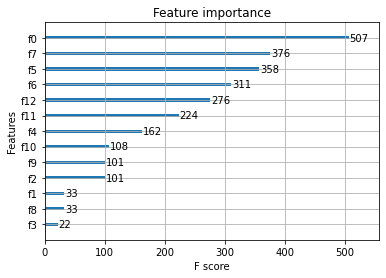

预测结果：
[28.273806 27.29072  20.129337]
[23.9 22.  11.9]


In [3]:
# 参数设置
params = {
    'booster': 'gbtree',
    'objective':'reg:linear',
    'max_depth':6,
    'eta':0.1,
    'silent':1,
    'gamma':0,
    'min_child_weight':1,
    'subsample':1,
    'colsample_bytree':1,
    'colsample_bylevel':1,
    'lambda':1,
    'alpha':0,
    'nthread':-1,
    'eval_metric':'rmse',
    'seed':0
}
# 验证集
evallist  = [(valid,'eval')]
# 模型训练
model = xgb.train(params.items(), train, 100, evals=evallist)
# 特征重要性
plot_importance(model)
plt.show()
# 预测
res = model.predict(test)
print('预测结果：')
print(res)
print(y_test)

# 3.1 参数调优
XGBoost调参主要用到其CV方法以及sklearn中的GridSearchCV、RandomizedSearchCV方法。这里继续以Boston房价为例。

首先，为了提高效率，设置eta为一个较大的值，确定其迭代次数，最后的时候再调小这个参数，进一步提高准确率。

In [4]:
params = {
    'booster': 'gbtree',
    'objective':'reg:linear',
    'max_depth':6,
    'eta':0.1,
    'silent':1,
    'gamma':0,
    'min_child_weight':1,
    'subsample':1,
    'colsample_bytree':1,
    'colsample_bylevel':1,
    'lambda':1,
    'alpha':0,
    'nthread':-1,
    'eval_metric':'rmse',
    'seed':0
}
cv = xgb.cv(params, train, num_boost_round=10000, nfold=3, metrics='rmse', early_stopping_rounds=10, seed=0)
print('Best round：',cv.shape[0])
print('Best score：',cv.values[-1,:])

Best round： 115
Best score： [0.19506767 0.00863104 3.503676   0.15066805]


从结果可以看出，eta=0.1的条件下，最优迭代次数是：70次，把相应的参数如此设置。

接下来使用GridSearchCV调其他参数，调整其他参数需要使用sklearn下的XGBoost。

15.64755886774853


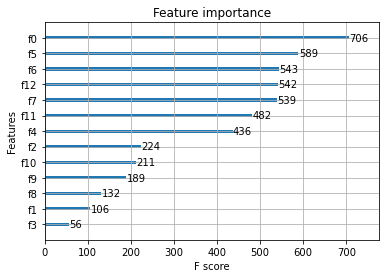

预测结果：
res: [26.627985 26.083345 20.829376]
y_test [23.9 22.  11.9]
Fitting 5 folds for each of 2520 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 3992 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 11792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  4.4min finished


Best params: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 190}
Best score: -9.823631843797596


In [5]:
# 网格调参
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 模型训练
model = xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=130, silent=True, 
                         objective='reg:linear', nthread=-1, gamma=0.1, min_child_weight=0, 
                         max_delta_step=0, subsample=0.5, colsample_bytree=0.8, colsample_bylevel=0.4, 
                         reg_alpha=0.4, reg_lambda=0.8, scale_pos_weight=1, base_score=0.5, seed=0, 
                         missing=None)
model.fit(x_train,y_train)
val = model.predict(x_valid)
print(mean_squared_error(y_valid,val))

# 特征重要性
plot_importance(model)
plt.show()

res = model.predict(x_test)
print('预测结果：')
print('res:',res)
print('y_test',y_test)

para = {
     'learning_rate':[0.3,0.1,0.05,0.03,0.01],
     'n_estimators':np.arange(50,200,20),
     'max_depth':np.arange(3,10,1),
     'gamma':np.arange(0.1,1,.1),
#     'min_child_weight':np.arange(0,5,1),
#     'subsample':np.arange(0.3,1,.1),
#     'colsample_bytree':np.arange(0.3,1,.1),
#     'colsample_bylevel':np.arange(0.3,1,.1),
#     'reg_alpha':np.arange(0,0.5,.1),
#     'reg_lambda':np.arange(0.5,1,.1),
}
cv = GridSearchCV(estimator=model,param_grid=para,scoring='neg_mean_squared_error',cv=5,verbose=1,n_jobs=-1)
cv.fit(x_train,y_train)
print("Best params:",cv.best_params_)
print('Best score:',cv.best_score_)